<a href="https://colab.research.google.com/github/phamxuansang241/BTL-KTLT/blob/main/bayes_multi_normal_gib_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sample mean (ybar): [46.01360316 50.00835936]
Sample covariance (S_sample):
[[131.0960373  161.97798317]
 [161.97798317 246.31534859]]

Quantiles (2.5%, 50%, 97.5%) cho (theta2 - theta1):
[0.26330243 4.00144447 7.57955662]

Pr(theta2 > theta1) = 0.9832


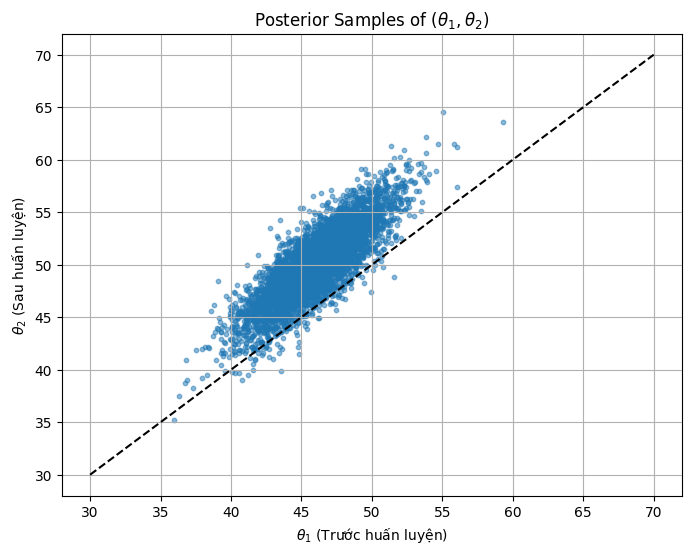

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invwishart, multivariate_normal

# --- Step 1: Sinh dữ liệu giả lập tương tự Reading Comprehension ---
np.random.seed(1)

n = 22
# Trung bình đúng như dữ liệu thực tế
mu_real = [47.18, 53.86]

# Ma trận hiệp phương sai thực tế
s1_squared = 182.16
s2_squared = 243.65
rho = 0.9
cov_real = [
    [s1_squared, rho * np.sqrt(s1_squared) * np.sqrt(s2_squared)],
    [rho * np.sqrt(s1_squared) * np.sqrt(s2_squared), s2_squared]
]

# Sinh dữ liệu
y_data = np.random.multivariate_normal(mean=mu_real, cov=cov_real, size=n)

# Cập nhật trung bình mẫu và phương sai mẫu từ dữ liệu đã sinh
ybar = y_data.mean(axis=0)
S_sample = np.cov(y_data.T)

print(f"Sample mean (ybar): {ybar}")
print(f"Sample covariance (S_sample):\n{S_sample}")

# --- Step 2: Thiết lập tiên nghiệm ---
mu0 = np.array([50, 50])
L0 = np.array([
    [625, 312.5],
    [312.5, 625]
])
nu0 = 4
S0 = L0.copy()

# --- Step 3: Gibbs Sampling ---
n_iter = 5000
THETA = []
SIGMA = []

# Khởi tạo Sigma tại S_sample
Sigma = S_sample.copy()

for s in range(n_iter):
    # --- Update theta ---
    inv_L0 = np.linalg.inv(L0)
    inv_Sigma = np.linalg.inv(Sigma)
    Lambda_n = np.linalg.inv(inv_L0 + n * inv_Sigma)
    mu_n = Lambda_n @ (inv_L0 @ mu0 + n * inv_Sigma @ ybar)
    theta = multivariate_normal.rvs(mean=mu_n, cov=Lambda_n)

    # --- Update Sigma ---
    residuals = y_data - theta  # Dùng toàn bộ dữ liệu
    S_theta = S0 + residuals.T @ residuals
    Sigma = invwishart.rvs(df=nu0+n, scale=S_theta)

    THETA.append(theta)
    SIGMA.append(Sigma)

THETA = np.array(THETA)
SIGMA = np.array(SIGMA)

# --- Step 4: Phân tích hậu nghiệm ---

# Hiệu số theta2 - theta1
theta_diff = THETA[:, 1] - THETA[:, 0]

# Các lượng tử hậu nghiệm
quantiles = np.percentile(theta_diff, [2.5, 50, 97.5])
print("\nQuantiles (2.5%, 50%, 97.5%) cho (theta2 - theta1):")
print(quantiles)

# Xác suất theta2 > theta1
prob = np.mean(THETA[:, 1] > THETA[:, 0])
print(f"\nPr(theta2 > theta1) = {prob:.4f}")

# --- Step 5: Vẽ biểu đồ posterior samples ---
plt.figure(figsize=(8,6))
plt.scatter(THETA[:,0], THETA[:,1], alpha=0.5, s=10)
plt.plot([30, 70], [30, 70], 'k--')
plt.xlabel(r'$\theta_1$ (Trước huấn luyện)')
plt.ylabel(r'$\theta_2$ (Sau huấn luyện)')
plt.title('Posterior Samples of $(\\theta_1, \\theta_2)$')
plt.grid(True)
plt.show()
